In [10]:
import os
import numpy as np
import pandas as pd
from time import sleep
from tqdm import tqdm
from PIL import Image
from pathlib import Path

import torch
from transformers import GLPNFeatureExtractor, GLPNForDepthEstimation
from transformers import MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

In [ ]:
processor_depth = GLPNFeatureExtractor.from_pretrained("vinvino02/glpn-nyu")
model_depth = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

processor_mask = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-small-coco")
model_mask = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-small-coco")

In [19]:
def get_depth(img):
    img = img.resize((512,512))
    inputs_d = processor_depth(img, return_tensors="pt").pixel_values

    import torch
    with torch.no_grad():
        outputs_d = model_depth(inputs_d)
        predicted_depth = outputs_d.predicted_depth
        predicted_depth.shape
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=inputs_d.shape[-2:],
                        mode="bicubic",
                        align_corners=False,
                )
    depth = prediction.squeeze().cpu().numpy()
    
    return depth

def get_mask(img):
    inputs_m = processor_mask(images=img, return_tensors="pt")
    outputs_m = model_mask(**inputs_m)
    predicted_semantic_map = processor_mask.post_process_semantic_segmentation(outputs_m, target_sizes=[img.size[::-1]])[0]

    return predicted_semantic_map

def get_nature_depth(img, label = None):
    #125:grass; 116:tree
    mask = get_mask(img)
    pre_depth = get_depth(img)
    
    mask = (np.array(mask) == label).astype(int) 
    pre_depth_mask = (pre_depth * mask).reshape(-1) [(pre_depth * mask).reshape(-1) != 0]
    
    return pre_depth_mask

In [20]:
input_dir = "D:/desk/depth_restoration/test_data_mhr"
output_file = "D:/desk/depth_restoration/depth.csv"

all_data = []
for image_path in tqdm(Path(input_dir).glob("*.jpg")):
    image = Image.open(image_path)
    image = image.resize((512,512))

    depth = get_nature_depth(image, label = 125)  #125:grass; 116:tree

    # Append data to list of all data
    data = {"filename": image_path.name}
    data["depth_mean"] = depth.mean()
    data["depth_max"] = depth.max()
    data["depth_min"] = depth.min()
    # data.update(depth)
    all_data.append(data)

# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["depth_mean"] + ["depth_max"] + ["depth_min"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

9it [00:51,  5.67s/it]


In [17]:
# Save data to CSV file
df = pd.DataFrame.from_records(all_data, columns=["filename"] + ["total_pixels"])
df.set_index("filename", inplace=True)
df.to_csv(output_file)

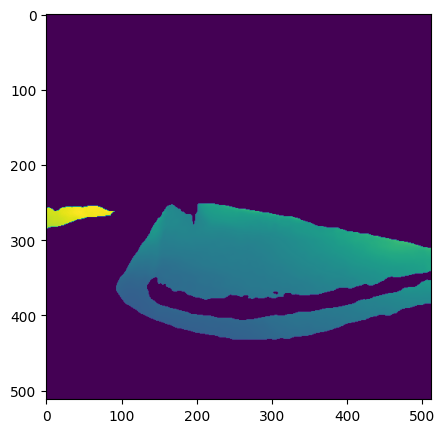

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.imshow(prediction * mask)
# plt.savefig("D:/desk/JNU/imgdepth.jpg", dpi = 600)